In [44]:
!pip install tldextract requests beautifulsoup4 scikit-learn xgboost lightgbm ucimlrepo langchain_community langchain_google_genai shodan tld whois dnspython dotenv

  Using cached shodan-1.31.0.tar.gz (57 kB)
  Preparing metadata (setup.py) ... done
  Using cached tld-0.13-py2.py3-none-any.whl.metadata (9.4 kB)
  Using cached whois-1.20240129.2-py3-none-any.whl.metadata (1.3 kB)
  Using cached dnspython-2.7.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached dotenv-0.0.5.tar.gz (2.4 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [62 lines of output]
        error: subprocess-exited-with-error
      
        × python setup.py egg_info did not run successfully.
        │ exit code: 1
        ╰─> [16 lines of output]
            Traceback (most recent call last):
              File "<string>", line 2, in <module>
              File "<pip-setuptools-caller>", line 14, in <module>
              File "/private/var/folders/h4/6fskxvrs7rd7njn7_n91zb780000gn/T/pip-wheel-tth1uzl7/distribute_6c662b8a5265435f8da20d92055f8e79/setuptools/__init_

In [45]:
# libraries
from dotenv import load_dotenv
import logging
import re
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
import json
from urllib.parse import urlparse
from bs4 import BeautifulSoup
import tldextract
import os 

from time import time
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
    learning_curve
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve
)
from sklearn.pipeline import Pipeline

from langchain_community.utilities import SerpAPIWrapper
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import PromptTemplate

load_dotenv()

True

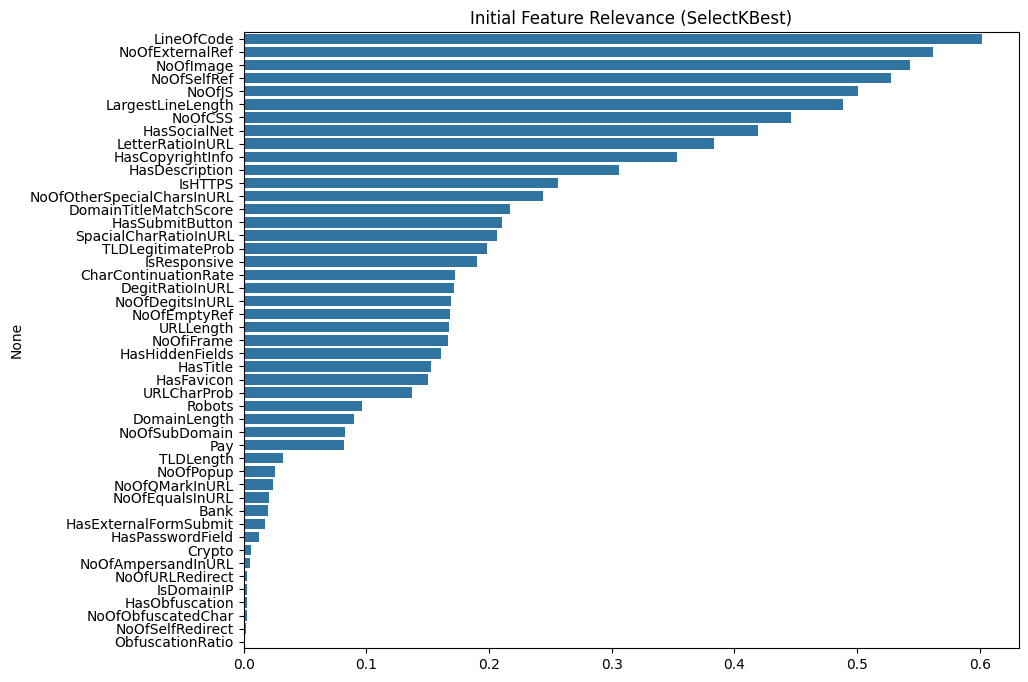

python(76122) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(76123) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(76124) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(76125) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(76126) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(76127) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(76128) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(76129) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


CV accuracy = 0.9986 +/- 0.0002

=== Test Set Evaluation ===
Accuracy: 0.9990
Precision: 0.9990
Recall: 0.9993
F1: 0.9991
Roc_Auc: 1.0000
Metrices:  {'accuracy': 0.9990033715727645, 'precision': 0.9989621557507691, 'recall': 0.9992955135335558, 'f1': 0.999128806836086, 'roc_auc': 0.9999920330187846}


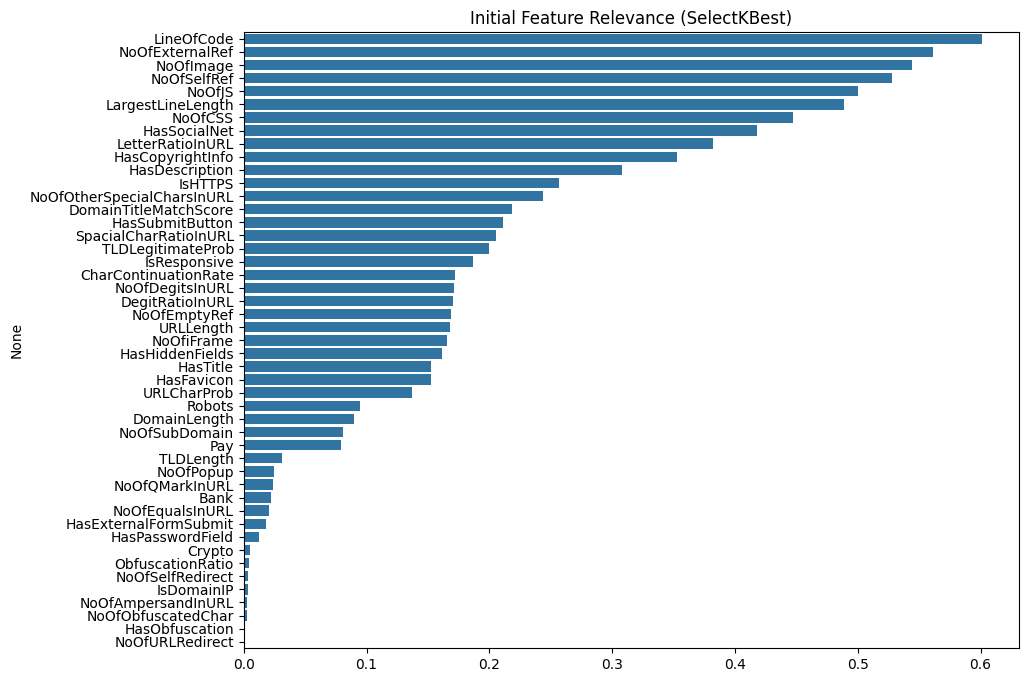

/Users/omarshehab/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/omarshehab/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/omarshehab/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/omarshehab/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:97: DataConversio

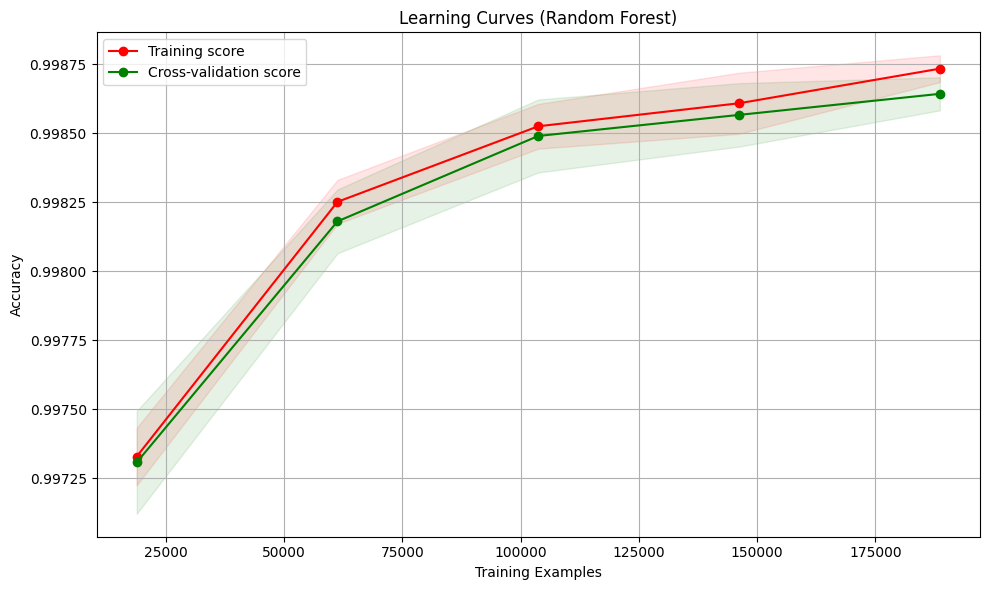


URL: https://www.google.com/
Prediction: Legitimate
Confidence: 99.98%
Phishing Probability: 0.02%
Legitimate Probability: 99.98%

URL: https://github.com/
Prediction: Legitimate
Confidence: 99.98%
Phishing Probability: 0.02%
Legitimate Probability: 99.98%

URL: https://www.amazon.com/
Prediction: Legitimate
Confidence: 99.98%
Phishing Probability: 0.02%
Legitimate Probability: 99.98%

URL: http://www.shprakserf.gq/
Prediction: Legitimate
Confidence: 78.82%
Phishing Probability: 21.18%
Legitimate Probability: 78.82%

URL: https://liuy-9a930.web.app/
Prediction: Legitimate
Confidence: 99.98%
Phishing Probability: 0.02%
Legitimate Probability: 99.98%


In [56]:
import warnings
warnings.filterwarnings('ignore')

logging.basicConfig(
    level=logging.INFO,
    filename='detector.log',
    format='%(asctime)s - %(levelname)s - %(message)s'
)

class URLPhishingDetector:
    def __init__(self):
        self.model = None
        self.scaler = None
        self.feature_names = None

        # for making web requests in extract_url_features
        self.headers = {
            'User-Agent': 'Mozilla/5.0'
        }

    ##################################################
    ## 1. Feature Extraction from a Single URL
    ##################################################
    def extract_url_features(self, url):
        """Extract features from a single URL."""
        try:
            features = {}
            parsed_url = urlparse(url)
            ext = tldextract.extract(url)

            # Basic numeric or ratio features
            features['URLLength']      = len(url)              
            features['DomainLength']   = len(ext.domain)
            features['TLD_Length']     = len(ext.suffix)

            # character distribution
            total_chars  = len(url)
            letter_count = len(re.findall(r'[a-zA-Z]', url))
            digit_count  = len(re.findall(r'\d', url))
            special_count= len(re.findall(r'[^a-zA-Z0-9]', url))
            features['LetterRatio']    = letter_count / total_chars if total_chars > 0 else 0
            features['DigitRatio']     = digit_count  / total_chars if total_chars > 0 else 0
            features['SpecialCharRatio'] = special_count / total_chars if total_chars > 0 else 0

            # subdomain / https / subdomain count
            features['IsHTTPS']        = 1 if url.startswith('https://') else 0
            features['HasSubdomain']   = 1 if ext.subdomain else 0
            features['SubdomainCount'] = len(ext.subdomain.split('.')) if ext.subdomain else 0

            # entropies
            features['URLEntropy']     = self._calculate_entropy(url)
            features['DomainEntropy']  = self._calculate_entropy(ext.domain)

            # Try to fetch page content
            try:
                response = requests.get(url, headers=self.headers, timeout=5)
                soup = BeautifulSoup(response.text, 'html.parser')

                features['ExternalResourceRatio'] = self._calculate_external_resource_ratio(soup, ext.domain)
                features['FormComplexity']        = self._calculate_form_complexity(soup)
                # Simple measure of text content vs. HTML size
                text_len = len(soup.get_text())
                html_len = len(response.text)
                features['ContentDensity']        = text_len / (html_len + 1)
            except Exception:
                # fallback if site can't be fetched
                features['ExternalResourceRatio'] = 0
                features['FormComplexity']        = 0
                features['ContentDensity']        = 0

            return features
        except Exception as e:
            logging.error(f"Error extracting features from URL: {e}")
            return None

    def _calculate_entropy(self, text):
        """Calculate Shannon entropy of a string."""
        if not text:
            return 0
        prob_dict = {c: text.count(c)/len(text) for c in set(text)}
        return -sum(p * np.log2(p) for p in prob_dict.values())

    def _calculate_external_resource_ratio(self, soup, domain):
        """Ratio of external to total resources."""
        internal_links = 0
        external_links = 0
        for tag in soup.find_all(['a', 'img', 'script', 'link']):
            href = tag.get('href', tag.get('src', ''))
            if href and not href.startswith(('data:', 'javascript:', '#')):
                if domain in href:
                    internal_links += 1
                else:
                    external_links += 1
        total = internal_links + external_links
        return external_links / total if total > 0 else 0

    def _calculate_form_complexity(self, soup):
        """Score how 'complex' forms are."""
        complexity = 0
        forms = soup.find_all('form')
        for form in forms:
            inputs = form.find_all('input')
            complexity += len(inputs)*0.2
            # if it has an absolute action URL
            if form.get('action', '').startswith(('http://','https://')):
                complexity += 0.5
        return min(complexity, 1.0)  # cap at 1.0

    ##################################################
    ## 2. Dataset Loading / Preprocessing
    ##################################################
    def load_and_prepare_data(self):
        """Load dataset and prepare features. Address potential leakage & missing data."""
        logging.info("Loading dataset from UCI (Phishing).")

        from ucimlrepo import fetch_ucirepo 
        phishing_dataset = fetch_ucirepo(id=967)

        X = phishing_dataset.data.features
        y = phishing_dataset.data.targets

        # Drop columns that might cause data leakage (URL, Domain, TLD, etc.)
        columns_to_drop = [
            'FILENAME', 'URL', 'Domain', 'Title', 'TLD', 'URLSimilarityIndex'
        ]
        X.drop(columns=columns_to_drop, inplace=True, errors='ignore')
        
        # remove highly correlated features to reduce overfitting
        corr_matrix = X.corr(numeric_only=True).abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        to_drop = [col for col in upper.columns if any(upper[col] > 0.95)]
        if to_drop:
            logging.info(f"Dropping highly correlated features: {to_drop}")
            X.drop(columns=to_drop, inplace=True, errors='ignore')

        # Perform a quick feature selection with SelectKBest or skip this step if you prefer all features
        from sklearn.feature_selection import SelectKBest, mutual_info_classif
        X_for_selection = X.fillna(0)
        selector = SelectKBest(mutual_info_classif, k='all')
        selector.fit(X_for_selection, y)
        scores = pd.Series(selector.scores_, index=X.columns).sort_values(ascending=False)

        # Plot feature scores
        plt.figure(figsize=(10,8))
        sns.barplot(x=scores.values, y=scores.index)
        plt.title("Initial Feature Relevance (SelectKBest)")
        plt.show()

        self.feature_names = X.columns.tolist()
        return X, y

    def build_random_forest_model(self):
        """Build a simpler Random Forest with more regularization."""
        rf = RandomForestClassifier(
            n_estimators=50,
            max_depth=6,          
            min_samples_split=20,
            min_samples_leaf=30,   
            max_features='sqrt',
            random_state=42,
            class_weight='balanced',
            n_jobs=-1,
            oob_score=True
        )
        
        calibrated_rf = CalibratedClassifierCV(
            rf,
            method='sigmoid', 
            cv=3
        )
        return calibrated_rf

    ##################################################
    ## 3. Training & Evaluation
    ##################################################
    def train(self):
        X, y = self.load_and_prepare_data()

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=42
        )

        y_train = y_train.values.ravel()    
        y_test = y_test.values.ravel()
        
        # Build pipeline:
        # 1) Impute missing
        # 2) Scale numeric
        # 3) Calibrated Random Forest
        pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
            ('rf', self.build_random_forest_model())
        ])

        # Cross-validation
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = cross_val_score(
            pipeline, X_train, y_train,
            scoring='accuracy',
            cv=cv,
            n_jobs=-1
        )
        logging.info(f"CV accuracy = {cv_scores.mean():.4f} +/- {cv_scores.std():.4f}")
        print(f"CV accuracy = {cv_scores.mean():.4f} +/- {cv_scores.std():.4f}")

        # Fit on entire training set
        pipeline.fit(X_train, y_train)

        # Evaluate on test set
        y_pred = pipeline.predict(X_test)
        y_proba = pipeline.predict_proba(X_test)[:,1]

        metrics = {
            'accuracy':  accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall':    recall_score(y_test, y_pred),
            'f1':        f1_score(y_test, y_pred),
            'roc_auc':   roc_auc_score(y_test, y_proba)
        }
        print("\n=== Test Set Evaluation ===")
        for k,v in metrics.items():
            print(f"{k.title()}: {v:.4f}")

        # store pipeline as self.model for later usage
        self.model = pipeline
        
        joblib.dump({
            'model': self.model,
            'scaler': self.scaler,
            'feature_names': self.feature_names
        }, 'random_forest_phishing_detector.pkl')
        logging.info("Trained model saved as 'random_forest_phishing_detector.pkl'")
        
        return metrics

    def predict(self, url):
        """Predict on a single URL."""
        if not self.model:
            raise Exception("Model not trained or loaded.")

        feats = self.extract_url_features(url)
        if not feats:
            return {"error": "Feature extraction failed."}

        df = pd.DataFrame([feats], columns=self.feature_names)
        # ensure all columns exist
        for col in self.feature_names:
            if col not in df.columns:
                df[col] = 0

        # do pipeline predictions
        probs = self.model.predict_proba(df[self.feature_names])[0]
        prediction = np.argmax(probs)
        confidence = max(probs)

        label = 'Phishing' if prediction == 0 else 'Legitimate'

        return {
            'url': url,
            'prediction': label,
            'confidence': float(confidence * 100),
            'probabilities': {
                'Phishing':    float(probs[0]*100),
                'Legitimate':  float(probs[1]*100)
            }
        }

    ##################################################
    ## 4. Visualization Helpers (optional)
    ##################################################
    def plot_learning_curves(self, model, X, y):
        """Plot learning curves for the given model."""
        train_sizes, train_scores, test_scores = learning_curve(
            model, X, y, cv=5, scoring='accuracy', n_jobs=-1,
            train_sizes=np.linspace(0.1, 1.0, 5), shuffle=True, random_state=42
        )

        # calculate mean and std for training and test scores
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        # plot learning curve
        plt.figure(figsize=(10, 6))
        plt.title("Learning Curves (Random Forest)")
        plt.xlabel("Training Examples")
        plt.ylabel("Accuracy")

        # plot training scores
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1, color="r")

        # plot cross-validation scores
        plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color="g")

        plt.legend(loc="best")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
    def load_model(self, filepath='random_forest_phishing_detector.pkl'):
        """Load a pre-trained model"""
        data = joblib.load(filepath)
        self.model = data['model']
        self.scaler = data['scaler']
        self.feature_names = data['feature_names']
        logging.info(f"Model loaded from {filepath}")
        print(f"Model loaded from {filepath}")
        
def main():
    detector = URLPhishingDetector()
    metrics = detector.train()
    print("Metrices: ", metrics)
    # can you use the function plot_learning_curves to plot the learning curves?
    X, y = detector.load_and_prepare_data()
    detector.plot_learning_curves(detector.model, X, y)
    
    # Test on some known URLs
    test_urls = [
        'https://www.google.com/',
        'https://github.com/',
        'https://www.amazon.com/',
        'http://www.shprakserf.gq/',
        'https://liuy-9a930.web.app/',
    ]

    for url in test_urls:
        result = detector.predict(url)
        print("\nURL:", url)
        if 'error' in result:
            print("Error extracting features.")
        else:
            print("Prediction:", result['prediction'])
            print("Confidence: {:.2f}%".format(result['confidence']))
            print("Phishing Probability: {:.2f}%".format(result['probabilities']['Phishing']))
            print("Legitimate Probability: {:.2f}%".format(result['probabilities']['Legitimate']))

if __name__ == "__main__":
    main()


In [47]:
class IntegratedPhishingDetector:
    def __init__(self, gemini_key: str):
        self.llm = ChatGoogleGenerativeAI(model="gemini-pro", google_api_key=gemini_key)
        self.ml_model = None
        self.scaler = StandardScaler()
        self.feature_names = None
        self.headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
        }
        logging.basicConfig(level=logging.INFO, filename='integrated_detector.log',
                          format='%(asctime)s - %(levelname)s - %(message)s')

    def extract_features(self, url):
        """Extract features used by both ML model and LLM"""
        logging.info(f"Extracting features from URL: {url}")
        try:
            features = {}

            # parse URL
            parsed_url = urlparse(url)
            ext = tldextract.extract(url)

            # basic URL features
            features['URLLength'] = len(url)
            # features['Domain'] = ext.domain + '.' + ext.suffix
            features['DomainLength'] = len(ext.domain)
            # features['TLD'] = ext.suffix
            features['URLSimilarityIndex'] = self._calculate_similarity_index(url)

            # character-based features
            features['NoOfLettersInURL'] = len(re.findall(r'[a-zA-Z]', url))
            features['NoOfDigitsInURL'] = len(re.findall(r'\d', url))
            features['NoOfSpecialCharsInURL'] = len(re.findall(r'[^a-zA-Z0-9]', url))

            # try to fetch and analyze webpage content
            try:
                response = requests.get(url, headers=self.headers, timeout=5)
                soup = BeautifulSoup(response.text, 'html.parser')

                # webpage content features
                features['IsHTTPS'] = 1 if url.startswith('https://') else 0
                features['HasFavicon'] = 1 if soup.find('link', rel='icon') else 0
                features['HasTitle'] = 1 if soup.title else 0
                features['Title'] = str(soup.title.string) if soup.title else ''

                # forms and fields
                forms = soup.find_all('form')
                features['HasExternalFormSubmit'] = int(any(
                    form.get('action', '').startswith(('http://', 'https://'))
                    for form in forms
                ))
                features['HasPasswordField'] = 1 if soup.find('input', type='password') else 0

                # page elements
                features['NoOfImages'] = len(soup.find_all('img'))
                features['NoOfLinks'] = len(soup.find_all('a'))
                features['HasHiddenFields'] = 1 if soup.find('input', type='hidden') else 0

            except Exception as e:
                logging.warning(f"Could not fetch webpage content: {e}")
                features.update({
                    'IsHTTPS': 1 if url.startswith('https://') else 0,
                    'HasFavicon': 0,
                    'HasTitle': 0,
                    'Title': '',
                    'HasExternalFormSubmit': 0,
                    'HasPasswordField': 0,
                    'NoOfImages': 0,
                    'NoOfLinks': 0,
                    'HasHiddenFields': 0
                })

            return features

        except Exception as e:
            logging.error(f"Error during feature extraction: {e}")
            return None

    def _calculate_similarity_index(self, url):
        """Calculate URL similarity index"""
        try:
            domain = tldextract.extract(url).domain
            if not domain:
                return 0
            unique_chars = len(set(domain))
            total_chars = len(domain)
            return (unique_chars / total_chars) * 100
        except:
            return 0

    def load_ml_model(self, filepath='random_forest_phishing_detector.pkl'):
        """Load the pre-trained ML model"""
        try:
            data = joblib.load(filepath)
            self.ml_model = data['model']
            self.scaler = data['scaler']
            self.feature_names = data['feature_names']
            logging.info(f"ML model loaded from {filepath}")
        except Exception as e:
            logging.error(f"Error loading ML model: {e}")
            raise

    def get_llm_prediction(self, url, features):
        """Get prediction from LLM using the same features as ML model"""
        template = """Analyze this URL for phishing indicators using the following features:

        URL: {url}

        FEATURES:
        {features}

        Based solely on these features, provide:
        1. ASSESSMENT: (SAFE or PHISHING)
        2. CONFIDENCE: (HIGH, MEDIUM, or LOW)
        3. RISK_SCORE: (0-100)
        4. REASONS: List specific features that influenced the decision
        """

        formatted_prompt = PromptTemplate(template=template).format(
            url=url,
            features=json.dumps(features, indent=2)
        )

        try:
            llm_response = self.llm.invoke(formatted_prompt).content
            parsed_response = self._parse_llm_response(llm_response)
            return parsed_response
        except Exception as e:
            logging.error(f"Error getting LLM prediction: {e}")
            return None

    def _parse_llm_response(self, response):
        """Parse LLM response into structured format"""
        assessment = "PHISHING"
        confidence = "LOW"
        risk_score = 50
        reasons = []

        try:
            response_upper = response.upper()
            if "ASSESSMENT: SAFE" in response_upper:
                assessment = "SAFE"

            confidence_matches = re.findall(r'CONFIDENCE:\s*(HIGH|MEDIUM|LOW)', response_upper)
            if confidence_matches:
                confidence = confidence_matches[0]

            risk_score_matches = re.findall(r'RISK_SCORE:\s*(\d+)', response)
            if risk_score_matches:
                risk_score = int(risk_score_matches[0])

            reasons_match = re.search(r'REASONS:(.*?)(CONFIDENCE|ASSESSMENT|RISK_SCORE|$)',
                                    response, re.DOTALL)
            if reasons_match:
                reasons = [r.strip() for r in reasons_match.group(1).split('\n')
                          if r.strip() and not r.startswith(('CONFIDENCE:', 'ASSESSMENT:', 'RISK_SCORE:'))]

        except Exception as e:
            logging.error(f"Error parsing LLM response: {e}")

        return {
            "assessment": assessment,
            "confidence": confidence,
            "risk_score": risk_score,
            "reasons": reasons
        }

    def analyze_url(self, url):
        """Analyze URL using both ML model and LLM"""
        if not self.ml_model:
            raise Exception("ML model not loaded. Call load_ml_model() first.")

        start_time = time()
        features = self.extract_features(url)

        if not features:
            return {
                "error": "Could not extract features from URL",
                "ml_prediction": None,
                "llm_prediction": None
            }

        # prepare features for ML model
        features_df = pd.DataFrame([features])
        for column in self.feature_names:
            if column not in features_df.columns:
                features_df[column] = 0
        
        # ML model prediction
        ml_prediction = self.ml_model.predict(features_df[self.feature_names])[0]
        ml_probability = self.ml_model.predict_proba(features_df[self.feature_names])[0]


        ml_result = {
            "prediction": "Legitimate" if ml_prediction == 1 else "Phishing",
            "confidence": float(max(ml_probability) * 100),
            "probabilities": {
                "Phishing": float(ml_probability[0] * 100),
                "Legitimate": float(ml_probability[1] * 100)
            }
        }

        # LLM prediction
        llm_result = self.get_llm_prediction(url, features)

        analysis_time = time() - start_time

        return {
            "url": url,
            "features": features,
            "ml_prediction": ml_result,
            "llm_prediction": llm_result,
            "analysis_time": analysis_time
        }

def main():
    detector = IntegratedPhishingDetector(gemini_key=os.getenv('GEMINI_KEY'))
    detector.load_ml_model()

    test_urls = [
        'http://www.teramill.com',
        'http://www.f0519141.xsph.ru',
        'http://www.shprakserf.gq',
        'https://service-mitld.firebaseapp.com/',
        'http://www.kuradox92.lima-city.de',
        'https://liuy-9a930.web.app/',
        'https://ipfs.io/ipfs/qmrvvyr84esa2assw9vvwupqjgsdn4c3dwkusfdwzdz3kn?clientid=noc@protocol.ai',
        'http://att-103731-107123.weeblysite.com/',
        'https://hidok4f8zl.firebaseapp.com/',
        'http://www.ooguy.com',
        'http://www.fairytalesinc.com',
        'http://www.iuhjn.pplink.club',
        'https://mechinchem-5cb8a.web.app/',
        'https://fb-restriction-case-97be5.web.app/',
        'https://pontosapontamentolu.com/gclid=',
        'http://www.komaru.today',
        'https://www.amazon.com/',
        'https://www.google.com/',
        'https://www.facebook.com/'
    ]

    for url in test_urls:
        print(f"\nAnalyzing URL: {url}")
        result = detector.analyze_url(url)
        print("\nResults:")
        print(json.dumps(result, indent=2))

if __name__ == "__main__":
    main()


Analyzing URL: http://www.teramill.com

Results:
{
  "url": "http://www.teramill.com",
  "features": {
    "URLLength": 23,
    "DomainLength": 8,
    "URLSimilarityIndex": 87.5,
    "NoOfLettersInURL": 18,
    "NoOfDigitsInURL": 0,
    "NoOfSpecialCharsInURL": 5,
    "IsHTTPS": 0,
    "HasFavicon": 1,
    "HasTitle": 1,
    "Title": "Parkovan\u00e1 dom\u00e9na www.teramill.com",
    "HasExternalFormSubmit": 1,
    "HasPasswordField": 0,
    "NoOfImages": 2,
    "NoOfLinks": 19,
    "HasHiddenFields": 1
  },
  "ml_prediction": {
    "prediction": "Phishing",
    "confidence": 99.99563375526671,
    "probabilities": {
      "Phishing": 99.99563375526671,
      "Legitimate": 0.00436624473329532
    }
  },
  "llm_prediction": {
    "assessment": "PHISHING",
    "confidence": "LOW",
    "risk_score": 50,
    "reasons": []
  },
  "analysis_time": 4.978060960769653
}

Analyzing URL: http://www.f0519141.xsph.ru

Results:
{
  "url": "http://www.f0519141.xsph.ru",
  "features": {
    "URLLengt